Simplex query for Peacocks.
Derived from matlab code: poly_query_peacock.mlx

In [1]:
from pathlib import Path
# Load the softmax encodings of the data

from sisap2023.utils.mirflickr import load_encodings

smData = load_encodings(Path('/Volumes/Data/mf_resnet50_softmax'))

# Load the data

allData = load_encodings(Path("/Volumes/Data/mf_dino2")) # load encodings

from sisap2023.utils.distances import l1_norm

allData = l1_norm(allData)

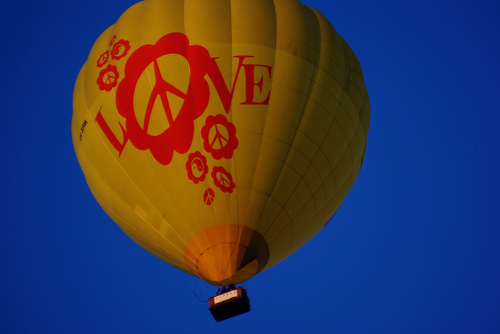

In [2]:
# Get the peacock at index 

from sisap2023.utils.mirflickr import get_mf_image

# 678   a balloon
# 67431 better balloon
# 689898; better balloon
# 74485; # red Virgin balloon

q0 = 990093 # yellow baloon

# The matlab query points - 74485	601442	736646

# the results from matlab: 744865 401614 990093 601442  565107  586042  715357  736646  941757  458302  951695
# 112045  683035  577581  576092  630161  600658  498312  123531


get_mf_image(q0)

In [3]:
from matplotlib import pyplot as plt

def imShow( image ):
    # plt.title(Image title")
    #plt.xlabel("X pixel scaling")
    # plt.ylabel("Y pixels scaling")

    fig = plt.figure(figsize = (1,1)) # in inches!
    plt.axis('off')
    plt.imshow(image) # figsize=(640/80,640/80), dpi=80)
    plt.show()

In [4]:
from sisap2023.utils.distances import get_dists
import numpy as np

dists = get_dists(q0,allData)
closest_indices = np.argsort(dists) # the closest images to the query
poly_query_indexes = closest_indices[0:6] # These are the indices we will use for the poly query
best_100_for_one = closest_indices[0:100]

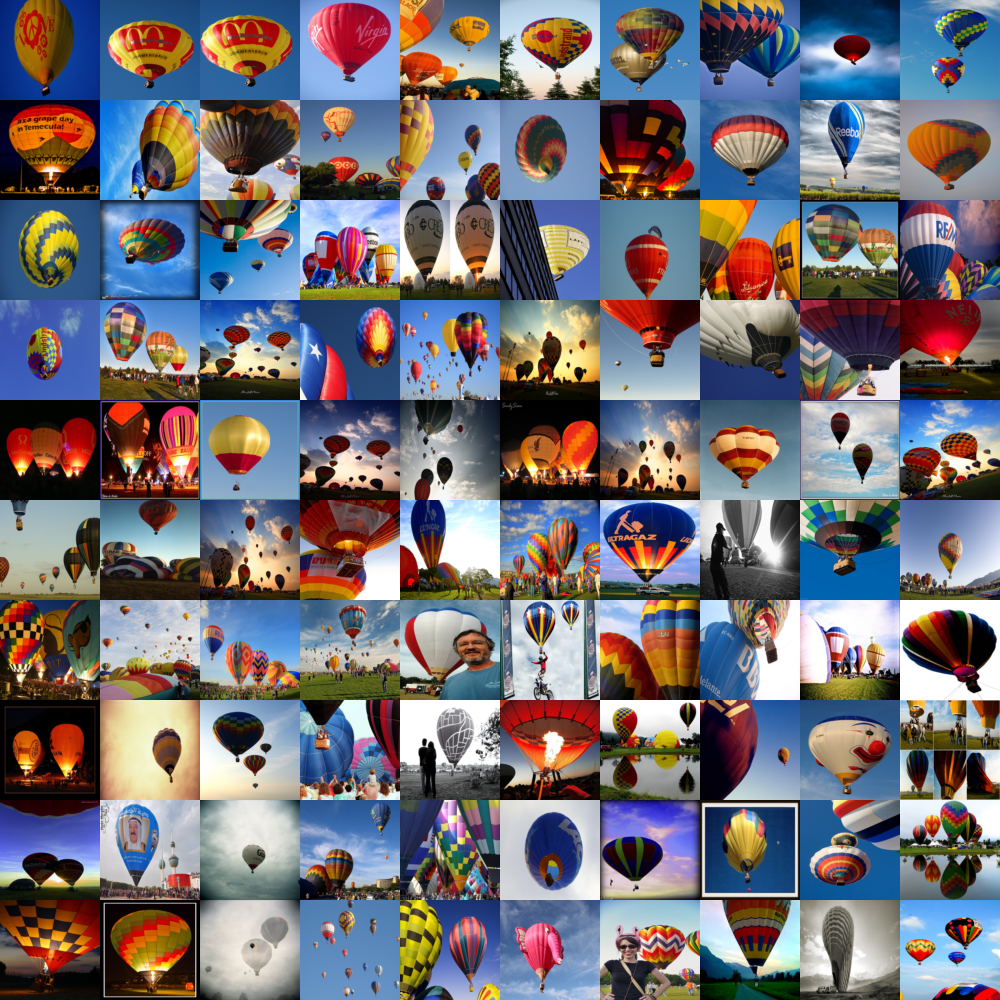

In [5]:
# These are the best images best on lowest average distance from the queries

from sisap2023.utils.mirflickr import make_mf_image_grid

make_mf_image_grid(best_100_for_one,10,10,100,100)



In [6]:
count = 1
for index in best_100_for_one:
    print( index, end='   ' )
    if count % 10 == 0:
        print()
    count = count + 1

990093   854117   854169   74485   334142   600658   367385   475510   490300   578592   
561315   124680   121234   577870   827338   598060   581948   125900   572651   565107   
915895   123531   67431   588171   465003   465006   533016   223581   732911   471767   
718262   739129   981772   509760   442011   981909   678   988732   592792   458302   
572416   722105   736646   984893   375066   998208   981142   728980   709353   985428   
715204   749148   982901   360673   587186   666839   586047   124304   293385   443674   
18522   448648   664836   452216   585532   466872   126659   571464   469329   562555   
897025   442568   509582   730660   490252   802941   558082   336901   112045   251364   
191376   174802   161160   123046   451306   573497   382910   278522   63956   557013   
872158   196762   423134   916534   659640   401614   654234   676446   107286   21328   


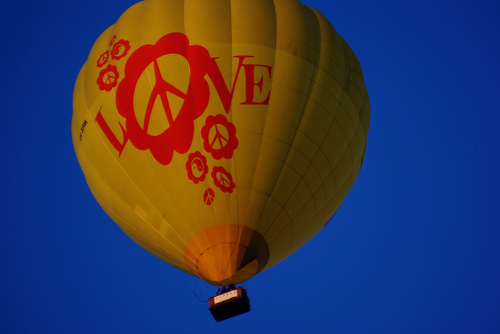

In [7]:
# yellow baloons

get_mf_image(990093)  

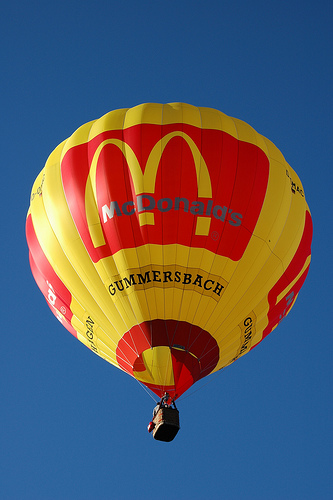

In [8]:
get_mf_image(854117)


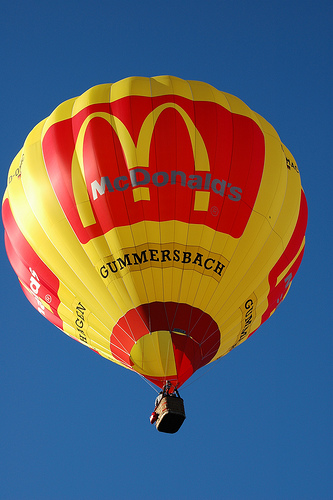

In [9]:
get_mf_image(854169)


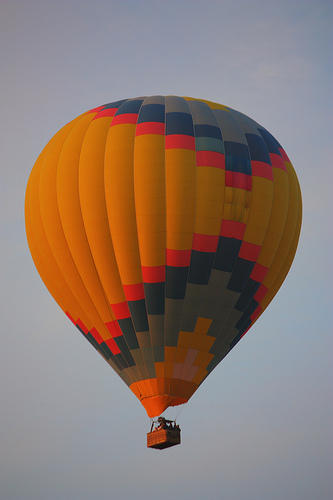

In [10]:
get_mf_image(565107)


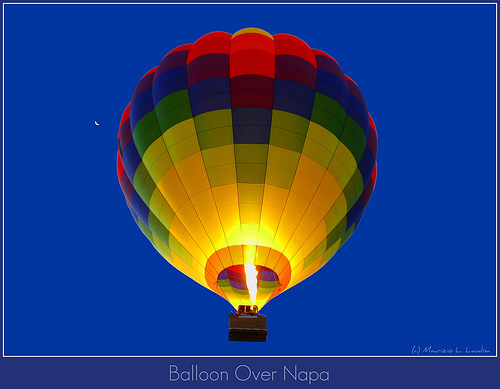

In [11]:

get_mf_image(48100)

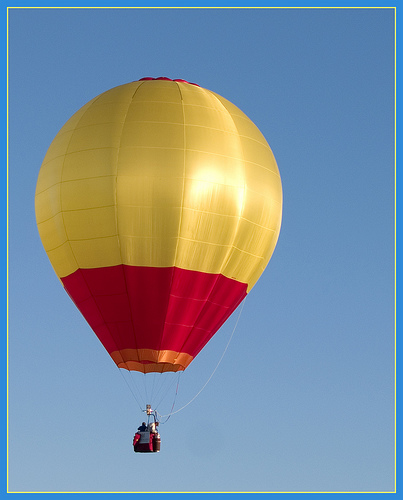

In [12]:
get_mf_image(736646)

In [13]:
# The mostly yellow ones
yellow_indices = [854117, 854169, 565107, 48100, 736646]
poly_query_data = allData[yellow_indices]

/Users/al/repos/sisap2023/sisap2023/metrics/msedOO.py:8: RuntimeWarning: invalid value encountered in log
  logs = np.log(X)                            # logs of shape no_of_objects,features
/Users/al/repos/sisap2023/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Users/al/repos/sisap2023/sisap2023/metrics/msedOO.py:35: RuntimeWarning: invalid value encountered in multiply
  product = new_comp * cprod;                 # product is a column vector: encode_size,1 print(f"product {product.shape}")


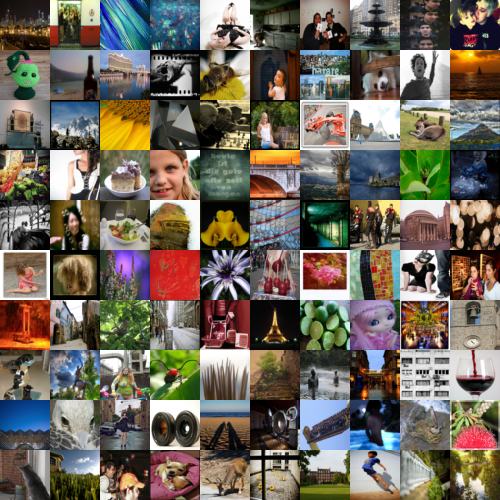

In [14]:
import numpy as np
from sisap2023.metrics.msedOO import msedOO

base = msedOO(poly_query_data)
complexities = base.msed(allData)
complexities = complexities.flatten()   # <<< these are all matrices of matrices shouldn't be.
indices = np.argsort(complexities)      # lowest is first
top_100 = indices[0:100]
make_mf_image_grid(top_100,10,10,50,50)

In [15]:
import math 
from sisap2023.metrics.euc import euc_scalar

from sisap2023.metrics.nsimplex import NSimplex
import numpy as np

def fromSimplexPoint(poly_query_distances : np.array, inter_pivot_distances : np.array, nn_dists:  np.array) -> np.array:
    '''poly_query_data is the set of reference points with which to build the simplex'''
    '''inter_pivot_distances are the inter-pivot distances with which to build the base simplex'''
    '''nn_dists is a column vec of distances, each abit more than the nn distance from each ref to the rest of the data set'''
    '''ie the "perfect" intersection to the rest of the set'''
    '''returns a np.array of distances between the perfect point and the rest of the data set'''

    nsimp = NSimplex()
    nsimp.build_base(inter_pivot_distances,False)

    # second param a (B,N)-shaped array containing distances to the N pivots for B objects.
    perfPoint = nsimp._get_apex(nsimp._base,nn_dists)    # was projectWithDistances in matlab

    for i in range(1000 * 1000):
        distvec = poly_query_distances[:,i];                      # a row vec of distances
        pr = nsimp._get_apex(nsimp._base,np.transpose(distvec));
        dists[i] = euc_scalar(pr,perfPoint)

    return dists


In [16]:
# from Italian documentation: README.md line 25
from scipy.spatial.distance import pdist, squareform

inter_pivot_distances = squareform(pdist(poly_query_data, metric=euc_scalar)) # pivot-pivot distance matrix with shape (n_pivots, n_pivots)

In [18]:
# Fetch the data and whole-set distances for the extra query objects
# fc6_poly_queries is the FC6 data for the queries we have chosen - not needed
# poly_query_distances is the distances from the queries to the all data 1000000,6

num_poly_queries = len(poly_query_indexes)

poly_query_distances = np.zeros((num_poly_queries,1000*1000))
for i in range(num_poly_queries):
    poly_query_distances[i] = get_dists(poly_query_indexes[i],allData) 


### Simplex Projection

First calculate the distances from the queries to all data as we will be needing them again

In [19]:
nsimp = NSimplex()
nsimp.build_base(inter_pivot_distances,False)
# print(xx._base.shape)
# print(xx._base)
# print(inter_pivot_distances.shape)
# print(inter_pivot_distances)

In [20]:
# Next, find last coord from the simplex formed by 6 query points

all_apexes = nsimp._get_apex(nsimp._base,np.transpose(poly_query_distances))
altitudes = all_apexes[:,num_poly_queries -1] # the heights of the simplex - last coordinate



AssertionError: Base size and number of distances should match, found 5 and 6)

In [ ]:
closest_indices = np.argsort(altitudes) # the closest images to the perfect point

best_100_for_simplex = closest_indices[0:100]

make_mf_image_grid(best_100_for_simplex,10,10,50,50)

In [ ]:
# Now want to report results the total count in the category

from sisap2023.utils.count_cats import count_number_in_cat_gt_thresh 
from sisap2023.utils.count_cats import count_number_in_results_in_cat

encodings_for_best_100_single = softmax_encodings[best_100_for_one] # the alexnet encodings for the best 100 average singlequery images
single_peacock_totals = encodings_for_best_100_single[:,balloon_category]
print("Total peacock sum for single query best 100: ", np.sum(single_peacock_totals))


encodings_for_best_100_average = softmax_encodings[best_100_for_simplex] # the alexnet encodings for the best 100 polyquery images
average_peacock_totals = encodings_for_best_100_average[:,balloon_category]
print("Total peacock sum for poly query best 100: ", np.sum(average_peacock_totals))

res = count_number_in_results_in_cat(balloon_category,0.9,best_100_for_one,softmax_encodings)
print("Total with thresh better than 0.9 single query : ", res)

res = count_number_in_results_in_cat(balloon_category,0.9,best_100_for_simplex,softmax_encodings)
print("Total with thresh better than 0.9 poly query : ", res)